In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('heart_2022_with_nans.csv')
# df.head()

df.loc[0]

State                                                                  Alabama
Sex                                                                     Female
GeneralHealth                                                        Very good
PhysicalHealthDays                                                         0.0
MentalHealthDays                                                           0.0
LastCheckupTime              Within past year (anytime less than 12 months ...
PhysicalActivities                                                          No
SleepHours                                                                 8.0
RemovedTeeth                                                               NaN
HadHeartAttack                                                              No
HadAngina                                                                   No
HadStroke                                                                   No
HadAsthma                                           

In [3]:
df.dropna(subset='CovidPos', axis=0, inplace=True)

In [4]:
df.dtypes
# list(df.select_dtypes('object').nunique()[df.select_dtypes('object').nunique() > 10].keys())
# df.isnull().any()

State                         object
Sex                           object
GeneralHealth                 object
PhysicalHealthDays           float64
MentalHealthDays             float64
LastCheckupTime               object
PhysicalActivities            object
SleepHours                   float64
RemovedTeeth                  object
HadHeartAttack                object
HadAngina                     object
HadStroke                     object
HadAsthma                     object
HadSkinCancer                 object
HadCOPD                       object
HadDepressiveDisorder         object
HadKidneyDisease              object
HadArthritis                  object
HadDiabetes                   object
DeafOrHardOfHearing           object
BlindOrVisionDifficulty       object
DifficultyConcentrating       object
DifficultyWalking             object
DifficultyDressingBathing     object
DifficultyErrands             object
SmokerStatus                  object
ECigaretteUsage               object
C

In [5]:
X = df.drop('CovidPos', axis=1)
y = pd.DataFrame(df['CovidPos'])

num_cols = list(X.select_dtypes('number').columns)
ordinal_cols = list(X.select_dtypes('object').nunique()[X.select_dtypes('object').nunique() > 10].keys())
onehot_cols = list(X.select_dtypes('object').nunique()[X.select_dtypes('object').nunique() <= 10].keys())
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
sample_row = X.iloc[0,:].to_dict()

In [6]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler()),
])

ordinal_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

onehot_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessing = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('ordinal_pipeline', ordinal_pipeline, ordinal_cols),
    ('onehot_pipeline', onehot_pipeline, onehot_cols)
])

model = XGBClassifier()

pipeline = Pipeline(steps=[
    ('transformers', preprocessing),
    ('model', model)
])

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_valid_encoded = le.transform(y_valid)

pipeline.fit(X_train, y_train_encoded)
preds = pipeline.predict(X_valid)

print(f'accuracy: {accuracy_score(y_valid_encoded, preds)}')

/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


accuracy: 0.68691837614423


(array([0, 1, 2]),
 [Text(0, 0, 'No'),
  Text(1, 0, 'Tested positive using home test without a health professional'),
  Text(2, 0, 'Yes')])

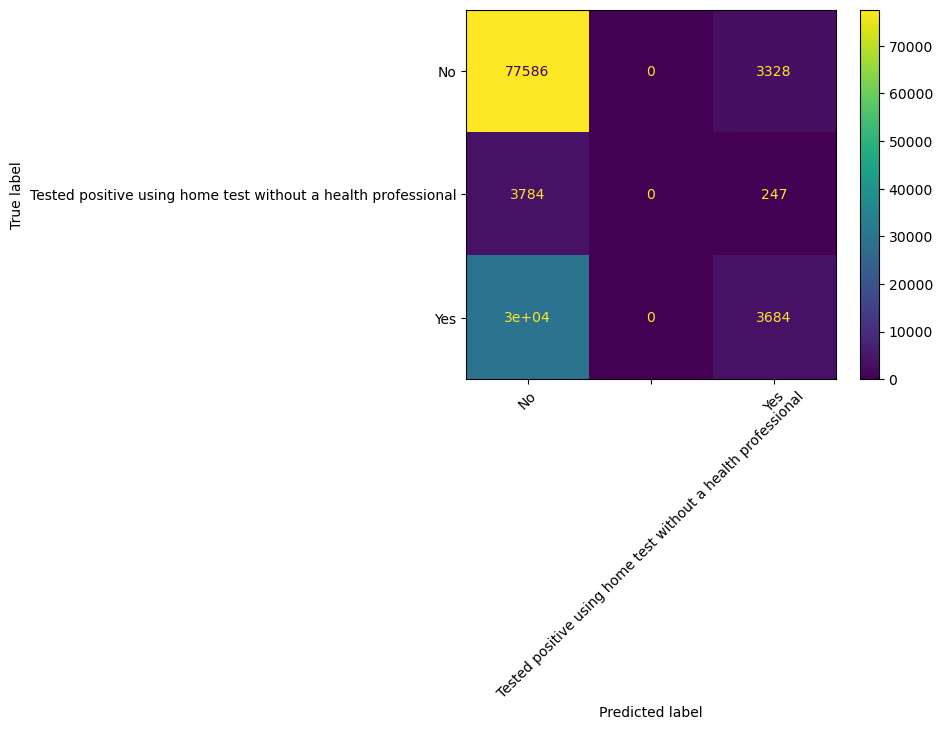

In [7]:
# le.inverse_transform(preds)

# y_valid['CovidPos'] == le.inverse_transform(preds)
cm = confusion_matrix(y_valid['CovidPos'], le.inverse_transform(preds))
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot()
plt.xticks(rotation=45)

In [8]:
import pickle

with open('pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(le, file)

In [10]:
from typing import Optional
from pydantic import BaseModel, Field, ValidationError

class Patient(BaseModel):
    state: object = Field(..., alias='State')
    sex: object = Field(..., alias='Sex')
    general_health: object = Field(..., alias='GeneralHealth')
    physical_health_days: Optional[float] = Field(None, alias='PhysicalHealthDays')
    mental_health_days: Optional[float] = Field(None, alias='MentalHealthDays')
    last_checkup_time: object = Field(..., alias='LastCheckupTime')
    physical_activities: object = Field(..., alias='PhysicalActivities')
    sleep_hours: Optional[float] = Field(None, alias='SleepHours')
    removed_teeth: object = Field(..., alias='RemovedTeeth')
    had_heart_attack: object = Field(..., alias='HadHeartAttack')
    had_angina: object = Field(..., alias='HadAngina')
    had_objectoke: str = Field(..., alias='HadStroke')
    had_asthma: object = Field(..., alias='HadAsthma')
    had_skin_cancer: object = Field(..., alias='HadSkinCancer')
    had_copd: object = Field(..., alias='HadCOPD')
    had_depressive_disorder: object = Field(..., alias='HadDepressiveDisorder')
    had_kidney_disease: object = Field(..., alias='HadKidneyDisease')
    had_arthritis: object = Field(..., alias='HadArthritis')
    had_diabetes: object = Field(..., alias='HadDiabetes')
    deaf_or_hard_of_hearing: object = Field(..., alias='DeafOrHardOfHearing')
    blind_or_vision_difficulty: object = Field(..., alias='BlindOrVisionDifficulty')
    difficulty_concentrating: object = Field(..., alias='DifficultyConcentrating')
    difficulty_walking: object = Field(..., alias='DifficultyWalking')
    difficulty_dressing_bathing: object = Field(..., alias='DifficultyDressingBathing')
    difficulty_errands: object = Field(..., alias='DifficultyErrands')
    smoker_status: object = Field(..., alias='SmokerStatus')
    e_cigarette_usage: object = Field(..., alias='ECigaretteUsage')
    chest_scan: object = Field(..., alias='ChestScan')
    race_ethnicity_category: object = Field(..., alias='RaceEthnicityCategory')
    age_category: object = Field(..., alias='AgeCategory')
    height_in_meters: Optional[float] = Field(None, alias='HeightInMeters')
    weight_in_kilograms: Optional[float] = Field(None, alias='WeightInKilograms')
    bmi: Optional[float] = Field(None, alias='BMI')
    alcohol_drinkers: object = Field(..., alias='AlcoholDrinkers')
    hiv_testing: object = Field(..., alias='HIVTesting')
    flu_vax_last_12: object = Field(..., alias='FluVaxLast12')
    pneumo_vax_ever: object = Field(..., alias='PneumoVaxEver')
    tetanus_last_10_tdap: object = Field(..., alias='TetanusLast10Tdap')
    high_risk_last_year: object = Field(..., alias='HighRiskLastYear')

with open('pipeline.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)
with open('label_encoder.pkl', 'rb') as file:
    loaded_le = pickle.load(file)

patient = Patient(**sample_row)
inputs = pd.DataFrame([patient.model_dump(by_alias=True)])
pred = loaded_pipeline.predict(inputs)
loaded_le.inverse_transform(pred)[0]

'No'

In [9]:
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        patient = Patient(**request.json)
        inputs = pd.DataFrame([patient.model_dump(by_alias=True)])
        pred = loaded_pipeline.predict(inputs)
        pred_actual = loaded_le.inverse_transform(pred)[0]
        response = {
            'prediction': pred_actual
        }
        return jsonify(response), 200
    except ValidationError as e:
        return jsonify(e.errors()), 400

if __name__=='__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.


SystemExit: 1

/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
